In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(1234)

import logging
logger = logging.getLogger('pystan')
logger.addHandler(logging.NullHandler())

import pystan
import scipy.stats as stats
import arviz

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# This library is needed for building Stan files in notebooks
import nest_asyncio
nest_asyncio.apply()

# This library is needed for multichain MCMC
import multiprocessing
multiprocessing.set_start_method("fork")

# Task Description

$a_{t} \in \{R, L\} (t = 1, ..., T)$

$r_{t} \in \{0, 1\} (t = 1, ..., T)$

In [77]:
df = pd.read_csv("./data/two_choice_task.csv")
actions = np.array(df["Choice (0: Left, 1: Right)"])
rewards = np.array(df["Outcome (0: Omission, 1: Rewarded)"])
rp_left = np.array(df["Reward Probability of the Left"])
rp_right = np.array(df["Reward Probability of the Right"])
df

,"Choice (0: Left, 1: Right)","Outcome (0: Omission, 1: Rewarded)",Reward Probability of the Left,Reward Probability of the Right
0,0,0,0.7,0.3
1,0,1,0.7,0.3
2,0,1,0.7,0.3
3,0,0,0.7,0.3
4,0,0,0.7,0.3
...,...,...,...,...
427,1,0,0.3,0.7
428,1,1,0.3,0.7
429,1,1,0.3,0.7
430,1,1,0.3,0.7


# Behavior Modeling 1: Logistic Regression Model

# Behavior Modeling 2: Reinforcement Learning Model

## Model 1: Q-Learning Model

Parameters:
- $\alpha$: Learning rate
- $\beta$: Inverse temperature

Model explaination:
- $Q(a, t)$: Action value for action $a$ at time $t$. ($a \in \{R, L\}$)
- Predicted action probability: $P(a_{t}=R) = \dfrac{1.0}{1.0 + \exp[-\beta (Q(R, t) - Q(L, t))]}$
- Value update (i.e $a_{t}=R$):
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & Q(R, t+1) = (1-\alpha)Q(R, t) + \alpha r_{t} \\
    & Q(L, t+1) = Q(L, t)
    \end{aligned}
\right.
\end{equation}$

Prior settings:
- Since $\alpha$ should be upper than 0 but lower than 1, we assume the Beta distribution as $\alpha$'s prior.
- Since $\beta$ should be non-negative real value, we assume the Gamma distribution as $\beta$'s prior.

$\begin{equation}
\left\{ \,
    \begin{aligned}
    & \alpha \sim Beta(2, 2) \\
    & \beta \sim Gamma(2, 3)
    \end{aligned}
\right.
\end{equation}$

Likelihood $P(A_{1:T}, R_{1:T}|\alpha, \beta)$:

$P(A_{1:T}, R_{1:T}|\alpha, \beta) = \prod_{t=1}^{T}P(a_{t}=A_{t}|A_{1:t-1}, R_{1:t-1}, \alpha, \beta)$

where $P(a_{t}=A_{t}|A_{1:t-1}, R_{1:t-1}, \alpha, \beta) = \dfrac{1.0}{1.0 + \exp[-\beta (Q(A_{t}, t) - Q(\bar{A}_{t}, t))]}$

Using "target +="

In [78]:
stan_q = """
data {
  int<lower=1> T ;               // Number of trials
  int<lower=1,upper=2> a[T];     // Actions (1: Left, 2: Right)
  real r[T];                     // Rewards
}

parameters {
  real<lower=0.0,upper=1.0> alpha;  // Learning rate
  real<lower=0.0> beta;             // Inverse temperature
}

model {
  matrix[2,T] Q; // Action values
  Q[1, 1] = 0;
  Q[2, 1] = 0;
  
  // Priors
  alpha ~ beta(2, 2);
  beta ~ gamma(2, 3);
  
  // Using 'for' iteration for time-series computation
  for ( t in 1:T ) {
    // Action selection
    // Adding a log-likelihood of a predicted action to "target"
    target += log( 1.0 / ( 1.0 + exp( -beta * (Q[a[t],t] - Q[3-a[t],t]) ) ) );
    
    // Value update
    if (t < T) {
      Q[a[t], t+1] = (1.0 - alpha) * Q[a[t], t] + alpha * r[t]; // Value update for a chosen action
      Q[3-a[t], t+1] = Q[3-a[t], t];                            // Value update for a unchosen action
    }
  }
}
"""

In [79]:
data_q = {
    "T": len(actions),
    "a": actions+1,
    "r": rewards
}

In [ ]:
sm = pystan.StanModel(model_code=stan_q)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_q, **sample_kwargs)

In [82]:
print(fit)

Inference for Stan model: anon_model_3b91db1eeff5413d06f8f3f88dcc0596.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.51  1.1e-3   0.08   0.34   0.45   0.51   0.56   0.67   5406    1.0
beta    2.73  4.2e-3    0.3   2.17   2.52   2.73   2.93   3.36   5159    1.0
lp__  -222.3    0.01   1.02 -225.1 -222.8 -222.0 -221.6 -221.3   5188    1.0

Samples were drawn using NUTS at Tue May 31 12:26:59 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


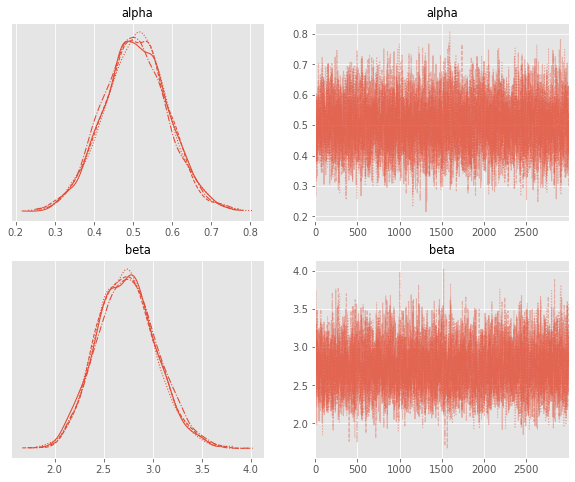

In [83]:
arviz.plot_trace(fit, var_names=('alpha', 'beta'), figsize=(10, 8));

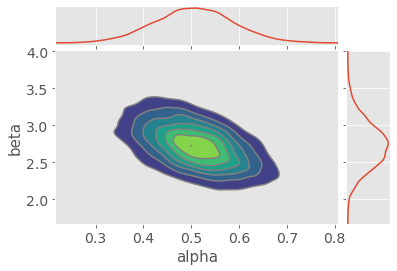

In [84]:
arviz.plot_pair(
    fit,
    var_names=['alpha', 'beta'],
    kind="kde",
    marginals=True
)
plt.show()

## Model 2: Q-Learning Model with Forgetting

Parameters:
- $\alpha$: Learning rate
- $\alpha_{F}$: Forgetting rate (How much information a subject forgets about an unselected choice at a previous trial)
- $\beta$: Inverse temperature

Model explaination:
- $Q(a, t)$: Action value for action $a$ at time $t$. ($a \in \{R, L\}$)
- Action selection: $P(a_{t}=R) = \dfrac{\exp(-\beta Q(R, t))}{\exp(-\beta Q(R, t)) + \exp(-\beta Q(L, t))}$
- Value update (i.e $a_{t}=R$):
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & Q(R, t+1) = (1-\alpha)Q(R, t) + \alpha r_{t} \\
    & Q(L, t+1) = (1-\alpha_{F})Q(L, t)
    \end{aligned}
\right.
\end{equation}$

Prior settings:
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & \alpha \sim Beta(2, 2) \\
    & \alpha_{F} \sim Beta(2, 2) \\
    & \beta \sim Gamma(2, 3)
    \end{aligned}
\right.
\end{equation}$

Using "target +="

In [10]:
stan_qf = """
data {
  int<lower=1> T ;               // Number of trials
  int<lower=1,upper=2> a[T];     // Actions (1: Left, 2: Right)
  real r[T];                     // Rewards
}

parameters {
  real<lower=0.0,upper=1.0> alpha;  // Learning rate
  real<lower=0.0,upper=1.0> alpha_F;  // Forgetting rate
  real<lower=0.0> beta;             // Inverse temperature
}

model {
  matrix[2,T] Q; // Action values
  
  // Priors
  alpha ~ beta(2, 2);
  alpha_F ~ beta(2, 2);
  beta ~ gamma(2, 3);
  
  // Using 'for' iteration for time-series computation
  for ( t in 1:T ) {
    // Action selection
    // Adding a log-likelihood of a predicted action to "target"
    target += log( exp(-beta * Q[a[t],t]) / (exp(-beta * Q[a[t],t]) + exp(-beta * Q[3-a[t],t])) ); 
    
    // Value update
    if (t < T) {
      Q[a[t], t+1] = (1.0 - alpha) * Q[a[t], t] + alpha * r[t]; // Value update for a chosen action
      Q[3-a[t], t+1] = (1.0 - alpha_F) * Q[3-a[t], t];          // Value update for a unchosen action
    }
  }
}
"""

In [ ]:
sm = pystan.StanModel(model_code=stan_q)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_q, **sample_kwargs)

In [82]:
print(fit)

Inference for Stan model: anon_model_3b91db1eeff5413d06f8f3f88dcc0596.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.51  1.1e-3   0.08   0.34   0.45   0.51   0.56   0.67   5406    1.0
beta    2.73  4.2e-3    0.3   2.17   2.52   2.73   2.93   3.36   5159    1.0
lp__  -222.3    0.01   1.02 -225.1 -222.8 -222.0 -221.6 -221.3   5188    1.0

Samples were drawn using NUTS at Tue May 31 12:26:59 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


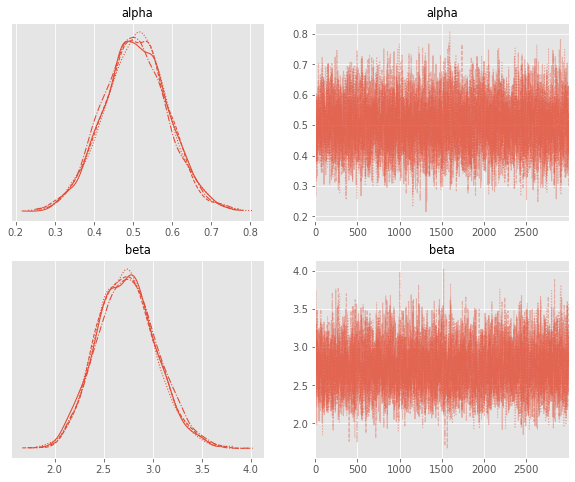

In [83]:
arviz.plot_trace(fit, var_names=('alpha', 'alpha_F', 'beta'), figsize=(10, 8));

## Model Comparison: Which model describes the behavioral data better?

### Methods
- Cross validation using test datasets
- Calculating information criteria

Here we select the best model by calculating Bayesian Information Criterion (BIC)